In [ ]:
#pip install yfinance

In [1]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1 fetch the data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [13]:
# 2 create features (column) for the model
def create_features(data):
    # calculate technical indicators
    # 10 day moving average
    data['MA10'] = data['Close'].rolling(window=10).mean()
    # 50 day moving average
    data['MA50'] = data['Close'].rolling(window=50).mean()
    # relative strength index (RSI)
    data['RSI'] = compute_rsi(data['Close'], 14)
    # daily return
    data['Daily_Return'] = data['Close'].pct_change()
    # 10 day daily volatility
    data['Volatility'] = data['Daily_Return'].rolling(window=10).std()    
    # create target variable (next day closing price)
    data['Target'] = data['Close'].shift(-1)
    # drop rows with NaN values
    data = data.dropna()
    return data

In [12]:
# 3 helper function to compute RSI
def compute_rsi(data,period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [7]:
# 4 prepare data for xgboost
def prepare_data(data,features):
    X = data[features]
    y = data['Target']
    return X, y  

In [ ]:
# 5 train the model and evaluate xgboost
def train_xgboost(X, y):
    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False,random_state=42)
    
    # initialize and train the model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    
    # trin the model
    model.fit(X_train, y_train)
    
    # make predictions
    y_pred = model.predict(X_test)
    
    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # print(f'Mean Squared Error: {mse}')
    # print(f'R^2 Score: {r2}')
    
    return model, X_test, y_test, y_train , X_train, y_pred , mse , r2
   

In [9]:
# 6 plot results
def plot_results(y_test, y_pred,dates):
    plt.figure(figsize=(12, 6))
    plt.plot(dates,y_test ,label='Actual Prices', color='blue')
    plt.plot(dates,y_pred, label='Predicted Prices', color='red')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/b1/q44029jx1wbdmqw13ddfzf7m0000gn/T/ipykernel_1974/3602043028.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Mean Squared Error: 3840.8656000431442
R^2 Score: 0.8683845103426047


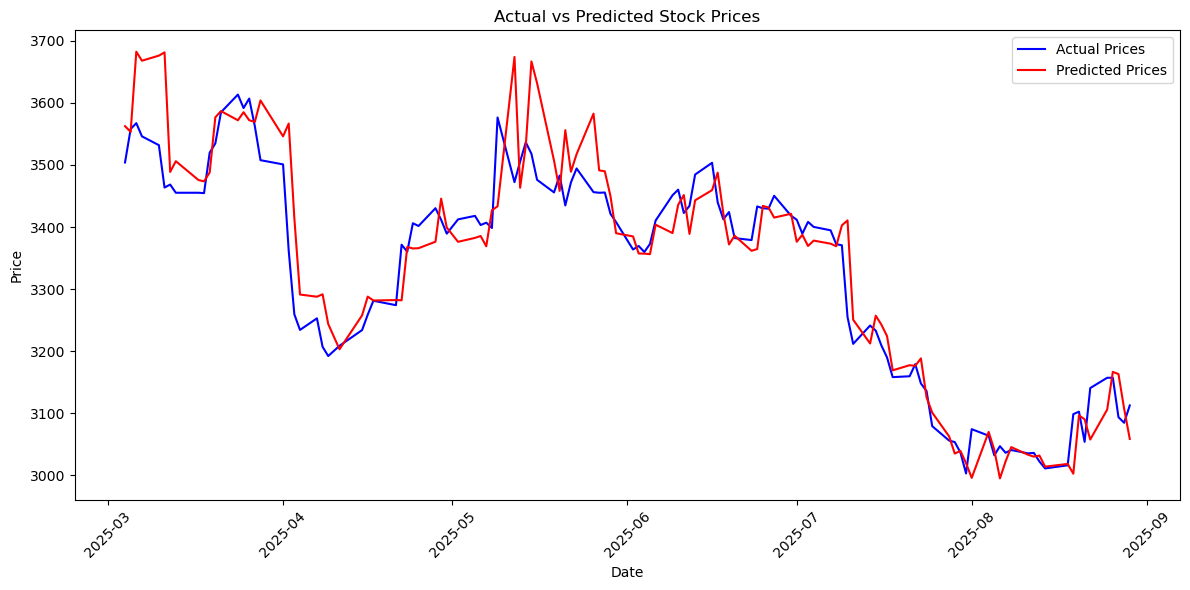

Feature Importance:
        Feature  Importance
0         Close    0.971880
1          MA10    0.011956
2          MA50    0.007848
5    Volatility    0.003539
3           RSI    0.002483
4  Daily_Return    0.002294


In [ ]:
if __name__ == "__main__":
    
    # parameters
    ticker = 'TCS.NS'
    start_date = '2023-01-01'
    end_date = '2025-09-02'
    
    data = fetch_stock_data(ticker, start_date, end_date)
    df = create_features(data)
    
    # define features to be used
    features = ['Close','MA10', 'MA50', 'RSI', 'Daily_Return', 'Volatility']
    
    # prepare data
    X, y = prepare_data(df, features)
    
    # train the model
    model, X_test, y_test, y_train , X_train, y_pred , mse , r2 = train_xgboost(X, y)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    
    # plot the results
    test_dates = df.index[-len(y_test):]
    plot_results(y_test, y_pred,test_dates)
    
    # feature importance
    features_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print("Feature Importance:")
    print(features_importance)

